# 1. Problem Framing

We are a data science consultancy that has been hired by a large hotel chain to investigate viable methods of mitigating the impact of short-notice customer cancellations. The approach taken in this analysis was to look at what characteristics of an individual may indicate that they are of a high probability to cancel. If an individual is deemed likely to cancel, they are charged a higher deposit at the point of purchase. This means that some of the lost revenue due to cancellation is recovered, thus reducing the overall cost to our client. We take ethics very seriously so for obvious reasons race, religion, gender and biological sex have not been considered. All customers will pay the same overall price (if they are purchasing the same product), it is only the initial deposit (as a % of the total price) that will change on a customer to customer basis.

# 2. Importing Libraries

In [1]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
from deslib.static.stacked import StackedClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

/Users/ravimalde/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# 2. Exploratory Data Analysis

In [2]:
df = pd.read_csv('H2.csv')

In [3]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


# 3. Preprocessing

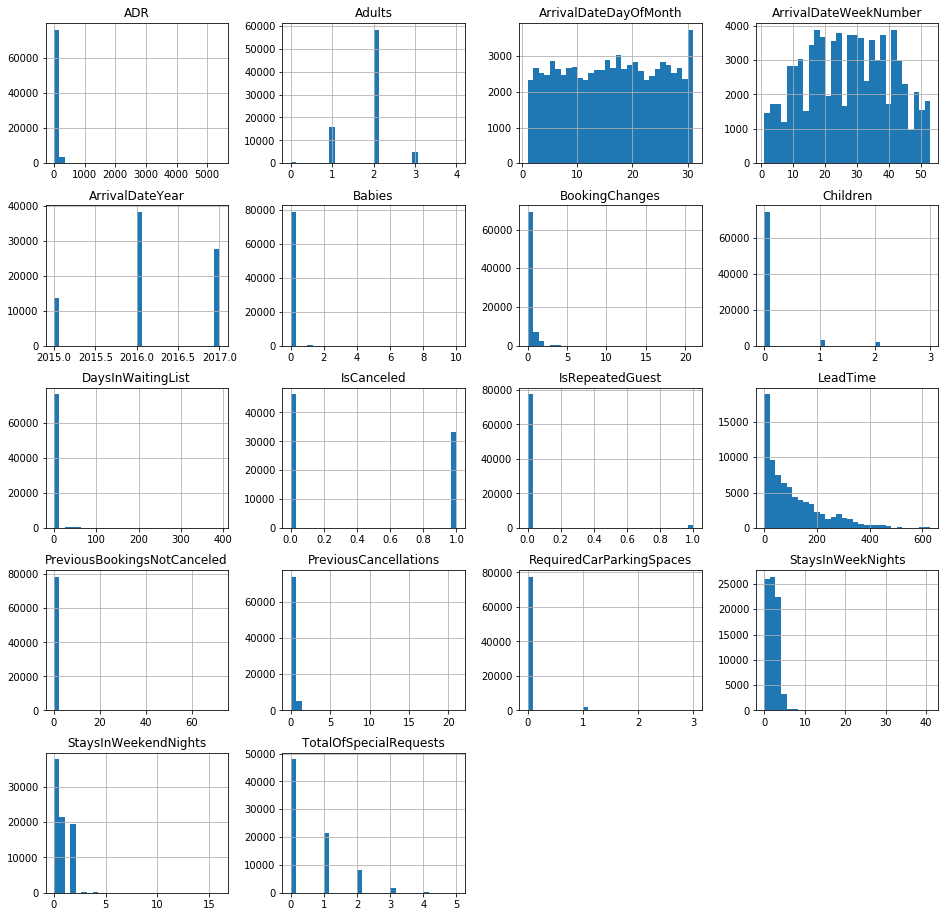

In [4]:
df.hist(bins=30, figsize=(16,16))
plt.show()

In [5]:
df.isna().sum().sum()

28

In [6]:
df = df.dropna()

In [7]:
df.isna().sum().sum()

0

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.drop(columns=['ReservationStatusDate', 'ReservationStatus'], inplace=True)

In [10]:
y = df[['IsCanceled']]
X = df.drop(columns=['IsCanceled','ArrivalDateYear'])

In [11]:
num_features = ['LeadTime',
            'StaysInWeekendNights',
            'StaysInWeekNights',
            'Adults',
            'Children',
            'Babies',
            'PreviousCancellations',
            'PreviousBookingsNotCanceled',
            'BookingChanges',
            'DaysInWaitingList',
            'ADR',
            'RequiredCarParkingSpaces',
            'TotalOfSpecialRequests']

df_num = X[num_features]

df_cat = X.drop(columns=num_features)

cat_features = list(df_cat.columns)

In [12]:
X = pd.get_dummies(X, columns=cat_features, drop_first=True)

In [13]:
X.isnull().sum()

LeadTime                        0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        0
                               ..
Company_        497             0
Company_       NULL             0
CustomerType_Group              0
CustomerType_Transient          0
CustomerType_Transient-Party    0
Length: 733, dtype: int64

In [14]:
X.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,...,Company_ 486,Company_ 489,Company_ 491,Company_ 492,Company_ 494,Company_ 497,Company_ NULL,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,6,0,2,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,88,0,4,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,65,0,4,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,92,2,4,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,100,0,2,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


# 4. Modelling

## 4.2. Scaling

In [15]:
X_2 = X.drop(columns=num_features)

In [16]:
scaler = StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X[num_features]))

In [17]:
X_s.columns = num_features

In [18]:
X_s = pd.concat([X_s, X_2], axis=1)

In [19]:
X_s.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,...,Company_ 486,Company_ 489,Company_ 491,Company_ 492,Company_ 494,Company_ 497,Company_ NULL,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,-0.934996,-0.898710,-0.125608,-1.672123,-0.245542,-0.058611,-0.191969,-0.078183,-0.30792,-0.154635,...,0,0,0,0,0,0,1,0,1,0
1,-0.195941,-0.898710,1.247936,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.30792,-0.154635,...,0,0,0,0,0,0,1,0,1,0
2,-0.403237,-0.898710,1.247936,-1.672123,-0.245542,-0.058611,-0.191969,-0.078183,-0.30792,-0.154635,...,0,0,0,0,0,0,1,0,1,0
3,-0.159890,1.361231,1.247936,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.30792,-0.154635,...,0,0,0,0,0,0,1,0,1,0
4,-0.087787,-0.898710,-0.125608,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.30792,-0.154635,...,0,0,0,0,0,0,1,0,1,0


## 4.3. Train-Test split

In [20]:
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_s, 
                                                                    y, 
                                                                    test_size=0.25, 
                                                                    random_state=50)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, 
                                                  y_train_initial, 
                                                  test_size=0.25,
                                                  random_state=50)

## 4.4. Modelling Class

In [22]:
skf = StratifiedKFold(n_splits=3,random_state=50)

In [23]:
class Classification():
    
    def __init__(self, , model, X_train, X_val, y_train, y_val):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Logistic Regression':
            self.instantiate = LogisticRegression(fit_intercept=False)
        elif self.model == 'Decision Tree':
            self.instantiate = DecisionTreeClassifier(random_state=50)
        elif self.model == 'Random Forest':
            self.instantiate = RandomForestClassifier(n_estimators=20, 
                                                          n_jobs=-1,
                                                          random_state=42)
        elif self.model == "SVM":
            self.instantiate = SVC(probability=True,
                                   random_state=50)
        
# SCORE FUNCTION -------------------------------------------------------------
        
    def scores(self, model, X_train, X_val, y_train, y_val):
        
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        
        train_auc = roc_auc_score(y_train, train_prob)
        val_auc = roc_auc_score(y_val, val_prob)
        
        self.train_auc = train_auc
        self.val_auc = val_auc
        
        self.scores_table = pd.DataFrame()
        
        self.scores_table["Model"] = [self.model]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]
        
        return self.scores_table
    
# THRESHOLD ANNOTATION -------------------------------------------------------


    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k % 100 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
            
# ROC PLOT FUNCTION ----------------------------------------------------------

    def roc_plot(model, X_train, X_val, y_train, y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]:
            fpr, tpr, thresh = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, thresh)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        
# GET SCORES FUNCTION --------------------------------------------------------

    def get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,
                                            self.best_model,
                                            self.X_train,
                                            self.X_val,
                                            self.y_train,
                                            self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
# OPTIMUM PLOT FUCNTION ------------------------------------------------------

    def opt_plots(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params, opt[cols]], axis=1, sort=False)
            
            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
            
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
# CONFUSION MATRIX FUNCTION --------------------------------------------------

    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
        
# DISPLAY PRETTY CONFUSION MATRIX FUNCTION -----------------------------------

    def pretty_conf_matrix(self):
        
        Classification.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

# PLOT DECISION TREE FUCNTION ------------------------------------------------

    def plot_dtree(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            
            dot_data = StringIO()
            export_graphviz(self.best_model, 
                            out_file=dot_data, 
                            filled=True,
                            rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
            graph.write_png(f'{self.model}.png')
            image = mpimg.imread(f'{self.model}.png')
            plt.figure(figsize=(50,50))
            plt.imshow(image)
            plt.show()
            
        else:
            
            print("This model does not have a decision tree plot!")
        

In [64]:
class Ensemble(Classification):
    
    def __init__(self, ensemble_method, estimators, X_train, X_val, y_train, y_val):
        
        self.ensemble_method = ensemble_method
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
        if self.ensemble_method == "Voting":
            self.instantiate = VotingClassifier(estimators=estimators, voting='soft')
            
    def ensemble_scores(self):

        train_prob = self.instantiate.predict_proba(self.X_train)[:,1]
        val_prob = self.instantiate.predict_proba(self.X_val)[:,1]

        train_auc = roc_auc_score(self.y_train, train_prob)
        val_auc = roc_auc_score(self.y_val, val_prob)

        self.train_auc = train_auc
        self.val_auc = val_auc

        self.scores_table = pd.DataFrame()

        self.scores_table["Model"] = [self.ensemble_method]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]

        return self.scores_table
    
    def ensemble_get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Ensemble.ensemble_scores(self)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
    
    def ensemble_pretty_conf_matrix(self):
        
        Ensemble.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

In [65]:
log_reg = ('lr', logistic_regression.best_model)
rand_forest = ('rnd', random_forest.best_model)
estimators = [log_reg, rand_forest]

In [66]:
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Voting,0.981654,0.9391


The best hyperparameters are:  {} 



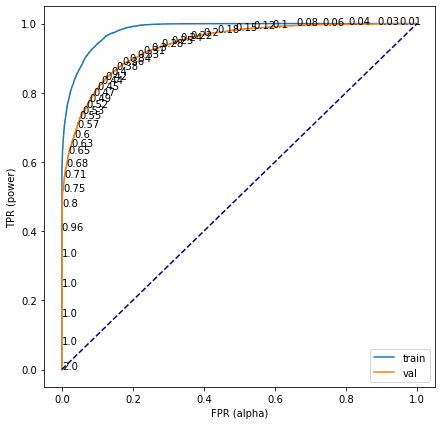

In [67]:
voting.ensemble_get_scores({}, skf)

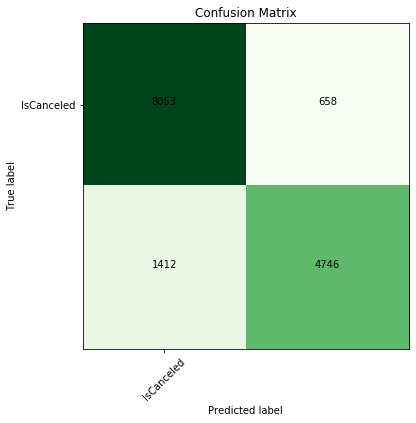

In [68]:
voting.ensemble_pretty_conf_matrix()

## 4.5. Logistic Regression

In [27]:
logistic_regression = Classification('Logistic Regression', X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.911448,0.906519


The best hyperparameters are:  {'C': 1} 



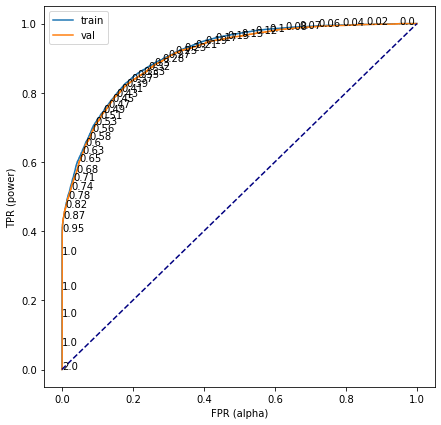

In [28]:
param_grid = {'C':[0.1,1,10,100]}
#               'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
logistic_regression.get_scores(param_grid, skf)

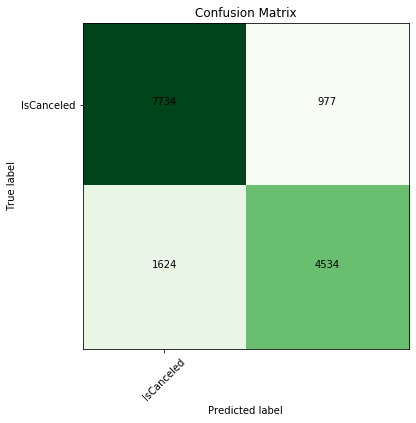

In [29]:
logistic_regression.pretty_conf_matrix()

## 4.6. Decision Trees

### 4.6.1. Iteration 1

In [ ]:
param_grid = {'max_depth':[10,100,500,1000], 'min_samples_leaf':[1,10,100,1000]}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

In [ ]:
decision_tree.opt_plots()

### 4.6.1. Iteration 2

In [ ]:
param_grid = {'max_depth':range(10,150,10), 'min_samples_leaf':range(50,150,10)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

In [ ]:
decision_tree.opt_plots()

### 4.6.1. Iteration 3

In [ ]:
param_grid = {'max_depth':range(15,25,1), 'min_samples_leaf':range(10,60,10)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

In [ ]:
decision_tree.opt_plots()

### 4.6.1. Iteration 4

In [ ]:
param_grid = {'max_depth':range(15,20,1), 'min_samples_leaf':range(25,35,1)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

In [ ]:
decision_tree.opt_plots()

In [ ]:
decision_tree.pretty_conf_matrix()

## 4.7. Random Forest

### 4.7.1. Iteration 1

In [ ]:
param_grid = {'max_depth':[10,100,500,1000], 'min_samples_leaf':[1,10,100,1000]}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

In [ ]:
random_forest.opt_plots()

### 4.7.2. Iteration 2

In [ ]:
param_grid = {'max_depth':range(50,150,10), 'min_samples_leaf':range(1,10,1)}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

In [ ]:
random_forest.opt_plots()

### 4.7.3. Iteration 3

,Model,Train AUC,Validation AUC
0,Random Forest,0.996691,0.944151


The best hyperparameters are:  {'max_depth': 42, 'min_samples_leaf': 1} 



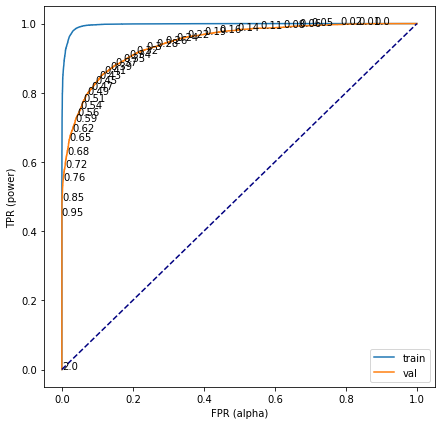

In [30]:
param_grid = {'max_depth':range(10,60,2), 'min_samples_leaf':range(1,3,1)}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

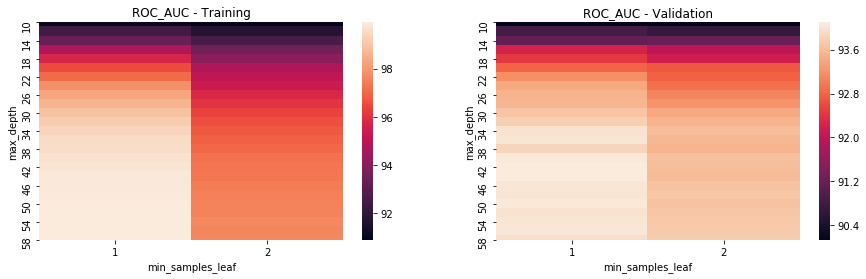

In [31]:
random_forest.opt_plots()

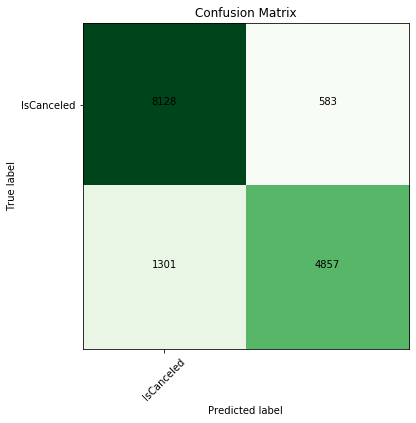

In [32]:
random_forest.pretty_conf_matrix()

# Ensemble Methods

## Voting Classifier

In [ ]:
voting = Classification('Voting', X_train, X_val, y_train, y_val)
param_grid = {}
voting.get_scores(param_grid, skf)

In [ ]:
voting.pretty_conf_matrix()

## AdaBoost